In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_input_eff
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import pandas as pd

In [ ]:
# Load the pre-trained EfficientNetB0 model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

def extract_efficientnet_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_eff(img_array)
    features = efficientnet_model.predict(img_array)
    return features.flatten()

In [ ]:
# Path to dataset
main_path = '/content/drive/My Drive/projects_data/fyp/Categorized_images'
train_set_path = '/content/drive/My Drive/projects_data/fyp/Train Set'
test_set_path = '/content/drive/My Drive/projects_data/fyp/Test Set'
efficientnet_model_path = '/content/drive/My Drive/projects_data/fyp/efficientnet_model.keras'
dir_list = os.listdir(main_path)
print(dir_list)

['Bad', 'Neutral', 'Good', 'Very Bad', 'Very Good']


In [ ]:
labels = {'Very Bad': 4, 'Bad': 3, 'Neutral': 2, 'Good': 1, 'Very Good': 0}
image_list = {'Very Bad': [], 'Bad': [], 'Neutral': [], 'Good': [], 'Very Good': []}

In [ ]:
for dir_name in dir_list:
    files_in_dir = os.listdir(f"{main_path}/{dir_name}")
    image_list[dir_name].extend(files_in_dir)

for list_ in image_list:
    print(list_, len(image_list[list_]))

Very Bad 600
Bad 600
Neutral 600
Good 600
Very Good 600


In [ ]:
categories = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Very Good']
for category in categories:
    os.makedirs(os.path.join(train_set_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_set_path, category), exist_ok=True)

In [ ]:
# Function to split and copy images
def split_and_copy_images(src_folder, dest_train_folder, dest_test_folder, test_size=0.2):
    for category in categories:
        category_path = os.path.join(src_folder, category)
        if not os.path.exists(category_path):
            print(f"Category path does not exist: {category_path}")
            continue

        images = os.listdir(category_path)
        if not images:
            print(f"No images found in: {category_path}")
            continue

        # Split images into train and test
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        print(f"Category: {category}")
        print(f"Total images: {len(images)}, Train images: {len(train_images)}, Test images: {len(test_images)}")

        # Copy images to the respective folders
        for img in train_images:
            src_path = os.path.join(category_path, img)
            dst_path = os.path.join(dest_train_folder, category, img)
            try:
                shutil.copy(src_path, dst_path)
            except Exception as e:
                print(f"Error copying image {src_path} to {dst_path}: {e}")

        for img in test_images:
            src_path = os.path.join(category_path, img)
            dst_path = os.path.join(dest_test_folder, category, img)
            try:
                shutil.copy(src_path, dst_path)
            except Exception as e:
                print(f"Error copying image {src_path} to {dst_path}: {e}")

# Split and copy images
split_and_copy_images(main_path, train_set_path, test_set_path)

Category: Very Bad
Total images: 600, Train images: 480, Test images: 120
Category: Bad
Total images: 600, Train images: 480, Test images: 120
Category: Neutral
Total images: 600, Train images: 480, Test images: 120
Category: Good
Total images: 600, Train images: 480, Test images: 120
Category: Very Good
Total images: 600, Train images: 480, Test images: 120


In [ ]:
# Prepare data for feature extraction
def prepare_data_for_feature_extraction(folder_path):
    X_images = []
    y = []
    for category in categories:
        category_path = os.path.join(folder_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                features = extract_efficientnet_features(img_path)
                X_images.append(features)
                y.append(labels[category])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return np.array(X_images), np.array(y)

In [ ]:
# Extract features from the train and test sets
X_train, y_train = prepare_data_for_feature_extraction(train_set_path)
X_test, y_test = prepare_data_for_feature_extraction(test_set_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Save the EfficientNet model
efficientnet_model.save(efficientnet_model_path)


In [ ]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Train Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

RandomForestClassifier(random_state=42)

In [ ]:
# Save the RF model
with open('/content/drive/My Drive/projects_data/fyp/EN_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

In [ ]:
# Evaluate the model
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')


Model Accuracy: 0.71


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=labels.keys(), columns=labels.keys())

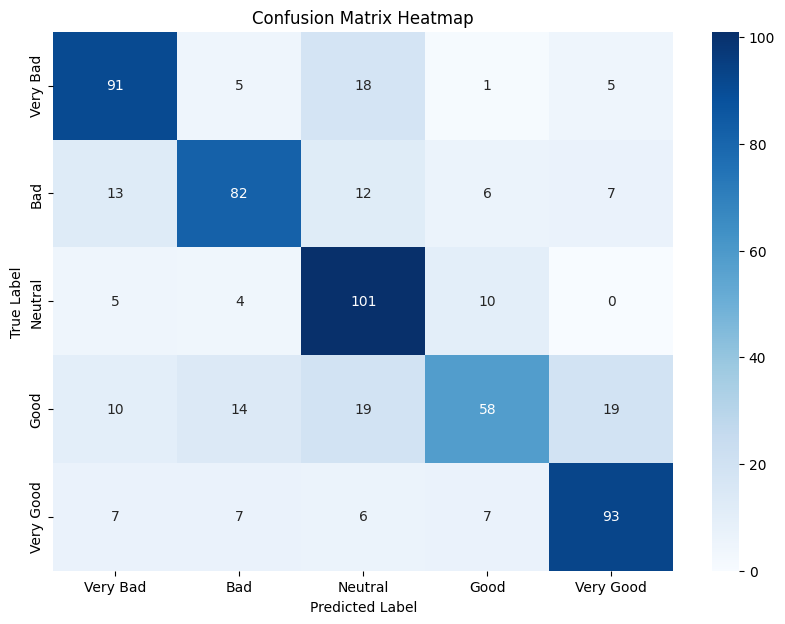

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=list(labels.keys()))

# Print the classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    Very Bad       0.72      0.76      0.74       120
         Bad       0.73      0.68      0.71       120
     Neutral       0.65      0.84      0.73       120
        Good       0.71      0.48      0.57       120
   Very Good       0.75      0.78      0.76       120

    accuracy                           0.71       600
   macro avg       0.71      0.71      0.70       600
weighted avg       0.71      0.71      0.70       600



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_input_eff
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

# Load the saved RandomForest classifier
EN_model_path = '/content/drive/My Drive/projects_data/fyp/EN_model.pkl'
with open(EN_model_path, 'rb') as file:
    EN_model_loaded = pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the efficientnet model
efficientnet_model_path = '/content/drive/My Drive/projects_data/fyp/efficientnet_model.keras'
efficientnet_model = tf.keras.models.load_model(efficientnet_model_path)

In [ ]:
# Function to preprocess and extract features from a single image
def extract_efficientnet_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_eff(img_array)
    features = efficientnet_model.predict(img_array)
    return features.flatten()

# Dictionary to map numerical labels back to category names
labels = {0: 'Very Good', 1: 'Good', 2: 'Neutral', 3: 'Bad', 4: 'Very Bad'}

# Path to a test image from the "Bad" category
test_image_path = '/content/drive/My Drive/projects_data/fyp/Test Set/Very Good/209.jpeg'

# Extract features from the test image
test_image_features = extract_efficientnet_features(test_image_path)

# Reshape the features to match the input shape expected by the Random Forest model
test_image_features = test_image_features.reshape(1, -1)

# Predict the label of the test image
predicted_label_index = EN_model_loaded.predict(test_image_features)[0]

# Get the predicted label name
predicted_label = labels[predicted_label_index]

print(f'Predicted Label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Label: Very Good
